- [ ] Import data
- [ ] Make into binary, based on a threshold
- [ ] Find the brighest row and column, i.e. the galaxu of our pixture. Might be able to use blob from skimage
- [ ] Rotate using some sort of PC(A?) to make it easier for our model to handle later. 
- [ ] Resise somewhere along this list to a format we choose. 

# preprocesing
- [ ] Check each image and check how many "blobs" they have. 
- [ ] Remove them 
- [ ] Check how many we have left.  

# Remove images where blob overlap 
- [ ] Check the rows we get in blob
- [ ] Using the middle point and a radius, if two blobs overlap
- [ ] We remove that image. 

In [18]:
%matplotlib inline

In [19]:
import skimage as ski
import numpy as np
import os 
import sys
import matplotlib.pyplot as plt

In [20]:
def get_image_path(galaxyID, test_true=False, train_true=False):
    if galaxyID is None:
        return None
    if isinstance(galaxyID, int):
        galaxyID = str(galaxyID)
    # Get the current working directory
    current_dir = os.getcwd()
    # Search through the subfolders for the image with the same ID
    search_dir = current_dir
    for root, dirs, files in os.walk(search_dir):
        for file in files:
            if file.startswith(galaxyID):
                return os.path.join(root, file)

    # If the image is not found, return None
    return None


In [21]:
get_image_path(747207)

'/workspaces/ClusteringGalaxies/images_training_subfolder23/747207.jpg'

In [22]:


# img = ski.io.imread(get_image_path(747207))
# img = ski.io.imread(get_image_path(262909))
# img = ski.io.imread(get_image_path(312941)) ##outlier, don't change
# img = ski.io.imread(get_image_path(732356))
# img = ski.io.imread(get_image_path(101151)) ##irregular
# img = ski.io.imread(get_image_path(458590)) ## long
# img = ski.io.imread(get_image_path(459014)) ##overlap
# img = ski.io.imread(get_image_path(856044)) ##overlap
# img = ski.io.imread(get_image_path(856535)) ##overlap
img = ski.io.imread(get_image_path(100295)) ##black stripe
# img = ski.io.imread(get_image_path(856758)) ##black stripe
# img = ski.io.imread(get_image_path(775905)) ##very inactive galaxy
# img = ski.io.imread(get_image_path(744265)) ##very bright background
# img = ski.io.imread(get_image_path(100008))


In [23]:
# print("Hello")
# raise SystemExit
# image_collection = ski.io.imread_collection('/images_training_rev1/*.jpg', conserve_memory=True)
# print("This should not run")

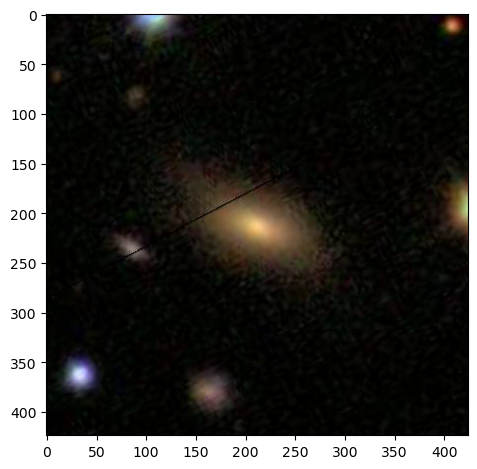

In [24]:
ski.io.imshow(img)

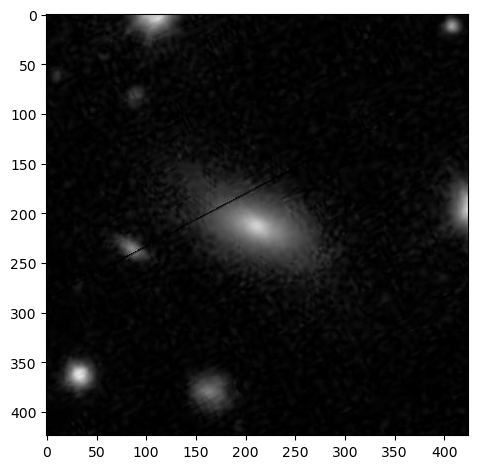

In [25]:
# Ignores colours, as that is mostly a factor of length and the shape of the galaxy is what we are aiming for. 
gray_img = ski.color.rgb2gray(img)
ski.io.imshow(gray_img)

In [26]:
class Galaxy:
    def __init__(self, x, y, sigma):
        self._x = x
        self._y = y
        self._sigma = sigma
    
    @property
    def center(self):
        return [self._x, self._y]
    
    @property
    def radius(self):
        factor = np.sqrt(2)
        return factor*self._sigma

def cropp_image(image, center_x, center_y, radius):
    return image[int(center_x-radius):int(center_x+radius), int(center_y-radius):int(center_y+radius)]

def overlap(image, galaxy1:Galaxy, galaxy2:Galaxy, verbose=False):
    top_galaxy, bottom_galaxy = (galaxy1, galaxy2) if galaxy1.center[1] > galaxy2.center[1] else (galaxy2, galaxy1) 
    # top_galaxy will be the one most to the bottom of the pictures
    # This is because of the pixel coordinates, where the y-axis is inverted
    
    D = np.sqrt((top_galaxy.center[0]-bottom_galaxy.center[0])**2 + (top_galaxy.center[1]-bottom_galaxy.center[1])**2)
    alpha = np.arcsin(abs(top_galaxy.center[0]-bottom_galaxy.center[0])/D)

    if top_galaxy.center[0] > bottom_galaxy.center[0]:
        alpha = np.pi/2 - alpha
    else:
        alpha = np.pi - alpha

    closest_point = [int(bottom_galaxy.center[0] + bottom_galaxy.radius*np.cos(alpha)), int(bottom_galaxy.center[1] + bottom_galaxy.radius*np.sin(alpha))]
    if verbose:
        print(f"Closest point: {closest_point}")
        print(f"Distance: {D}")
        print(f"Alpha: {alpha}")
        print(f"Top Galaxy center: {top_galaxy.center}")
        print(f"Bottom Galaxy center: {bottom_galaxy.center}")

        #plot the two galaxies
        ski.io.imshow(image)
        plt.plot(top_galaxy.center[0], top_galaxy.center[1], 'go')
        plt.plot(bottom_galaxy.center[0], bottom_galaxy.center[1], 'go')
        #plot the closest point onto the image
   
        plt.plot(closest_point[0], closest_point[1], 'ro')
        plt.show()
    if np.sqrt((closest_point[0]-top_galaxy.center[0])**2 + (closest_point[1]-top_galaxy.center[1])**2) < top_galaxy.radius:
        return True
    else:
        return False

def find_galaxy(image, window, verbose=False):
    blobs = ski.feature.blob_doh(image,
                                threshold=0.004, 
                                max_sigma = 100,
                                overlap=1)
    if verbose:
        print(blobs)
    image_center = [image.shape[0]//2, image.shape[1]//2]
    found_galaxy = None
    largest_sigma = 0
    blobs_in_window = []
    for b in blobs:
        if all(abs(b[i] - image_center[i]) < window for i in range(2)) and b[2] > largest_sigma:
            blobs_in_window.append(b)
            print(f"blob considered: {b[1]}, {b[2]}, {b[2]}")
            largest_sigma = b[2]
            found_galaxy = b

    if found_galaxy is None:
        print("No galaxy found. Returning None")
        return None
        
    found_galaxy = Galaxy(found_galaxy[1], found_galaxy[0], found_galaxy[2])

    for b in blobs:
        blob = Galaxy(b[1], b[0], b[2])
        if blob.center != found_galaxy.center:
            # Check if they overlap
            if overlap(image, found_galaxy, blob, verbose=True):
                if verbose:
                    print(f"There is overlap. x1={blob.center[0]}, y1={blob.center[1]}")
                return found_galaxy #REMOVE!
    return found_galaxy
            

[[363.  33.  12.]
 [  0. 109.  12.]
 [ 11. 107.  23.]
 [ 12. 407.  12.]
 [213. 212.  45.]
 [199. 417.  12.]
 [379. 164.  23.]
 [194. 411.  23.]
 [238.  88.   1.]
 [235.  85.  12.]]
blob considered: 212.0, 45.0, 45.0
Closest point: [171, 261]
Distance: 233.54014644167714
Alpha: 2.2682758241956407
Top Galaxy center: [33.0, 363.0]
Bottom Galaxy center: [212.0, 213.0]


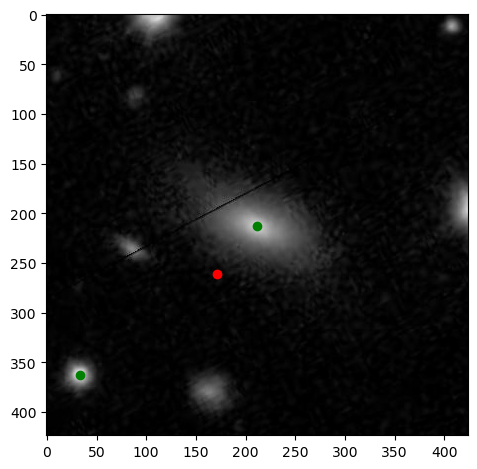

Closest point: [116, 15]
Distance: 236.59670327373541
Alpha: 1.120380459717679
Top Galaxy center: [212.0, 213.0]
Bottom Galaxy center: [109.0, 0.0]


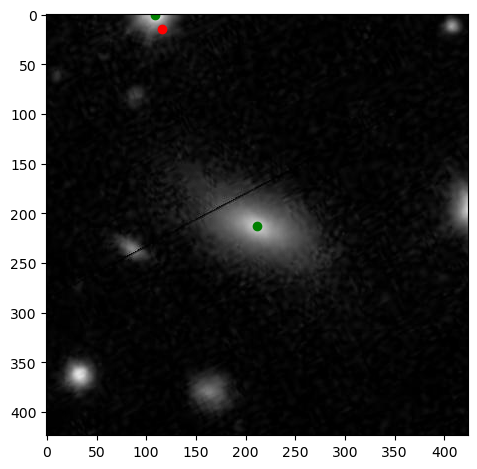

Closest point: [122, 39]
Distance: 227.65983396286663
Alpha: 1.0914329194464
Top Galaxy center: [212.0, 213.0]
Bottom Galaxy center: [107.0, 11.0]


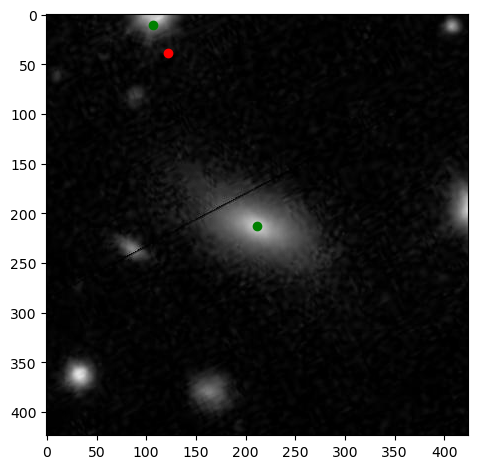

Closest point: [394, 23]
Distance: 280.0464247227591
Alpha: 2.3713448460671147
Top Galaxy center: [212.0, 213.0]
Bottom Galaxy center: [407.0, 12.0]


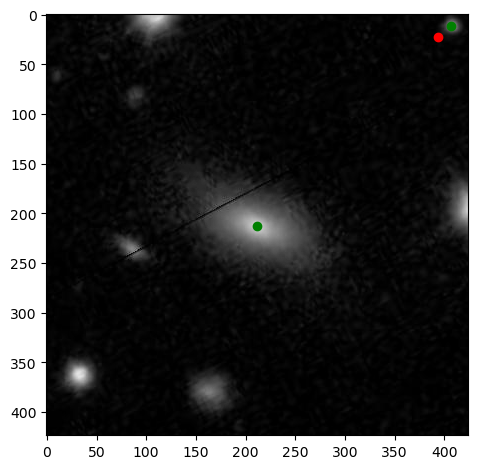

Closest point: [415, 215]
Distance: 205.47749268472205
Alpha: 1.638983135968362
Top Galaxy center: [212.0, 213.0]
Bottom Galaxy center: [417.0, 199.0]


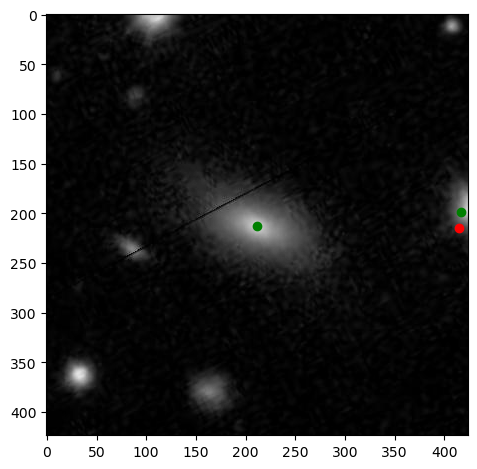

Closest point: [150, 230]
Distance: 172.80046296234278
Alpha: 2.8601133550617504
Top Galaxy center: [164.0, 379.0]
Bottom Galaxy center: [212.0, 213.0]


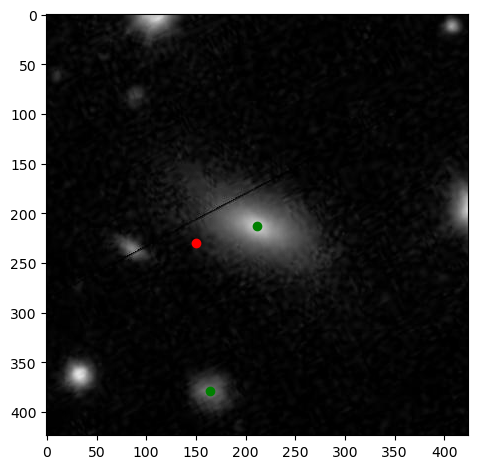

Closest point: [407, 226]
Distance: 199.90497742677644
Alpha: 1.6659851685375238
Top Galaxy center: [212.0, 213.0]
Bottom Galaxy center: [411.0, 194.0]


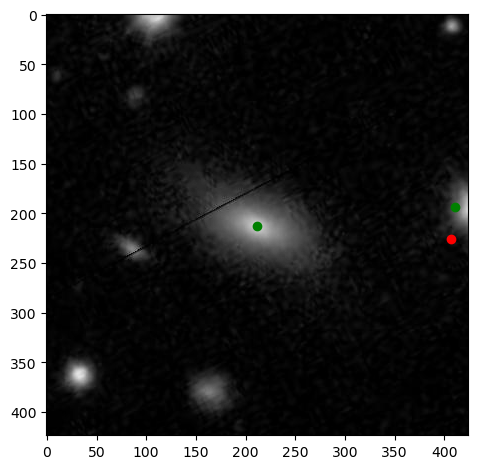

Closest point: [199, 275]
Distance: 126.49505919204908
Alpha: 1.7697422729994552
Top Galaxy center: [88.0, 238.0]
Bottom Galaxy center: [212.0, 213.0]


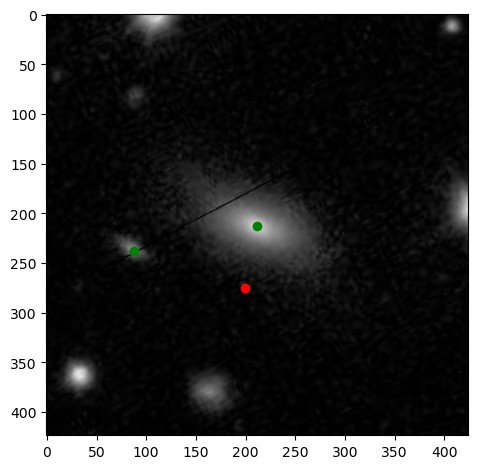

Closest point: [201, 275]
Distance: 128.89142717807107
Alpha: 1.7423224687669967
Top Galaxy center: [85.0, 235.0]
Bottom Galaxy center: [212.0, 213.0]


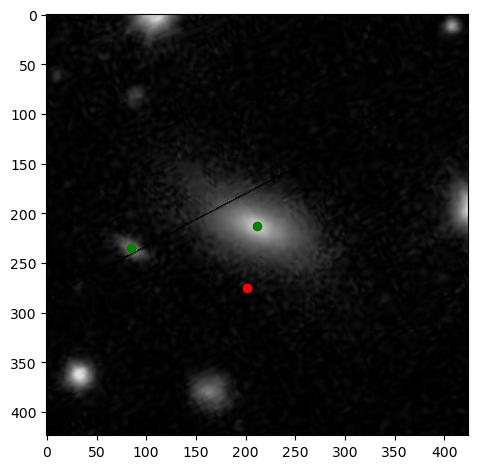

In [27]:

galaxy = find_galaxy(gray_img, window=50, verbose=True)

In [28]:
def check_for_black_stripe(image):
    # If there is at least 10 dark pixels in a row of any angle that are surrounded by light pixels, then there is a black stripe
    # image is cropped and gray scaled

    dark_pixel_threshold = 0.1
    dark_pixel_count_threshold = 15
    bright_pixel_threshold = 0.2

    dark_pixels = []
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i][j] < dark_pixel_threshold:
                dark_pixels.append([i,j])
    
    bright_pixels = []
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i][j] > bright_pixel_threshold:
                bright_pixels.append([i,j])


    suspicious_pixels = []
    # Look at a window around each dark pixel
    # If the mean of the pixels in the window is above the bright pixel threshold, add it to the list of suspicious pixels
    for pixel in dark_pixels:
        window = 5
        window_pixels = []
        for i in range(pixel[0]-window, pixel[0]+window):
            for j in range(pixel[1]-window, pixel[1]+window):
                if i >= 0 and i < image.shape[0] and j >= 0 and j < image.shape[1]:
                    window_pixels.append(image[i][j])
        if np.mean(window_pixels) > bright_pixel_threshold:
            suspicious_pixels.append(pixel)

    # Plot the suspicious pixels onto the image

    #Plot the dark pixels onto the image
    ski.io.imshow(image)
    
    for pixel in bright_pixels:
        plt.plot(pixel[1], pixel[0], 'bo')
    for pixel in dark_pixels:
        plt.plot(pixel[1], pixel[0], 'ro')
    for pixel in suspicious_pixels:
        plt.plot(pixel[1], pixel[0], 'go')
    plt.show()

    # How many suspicious pixels are there?
    if len(suspicious_pixels) > dark_pixel_count_threshold:
        # Do linear regression on the suspicious pixels
        # If the R^2 value is high, then there is a black stripe

        # Get the x and y values of the suspicious pixels
        x = []
        y = []
        for pixel in suspicious_pixels:
            x.append(pixel[0])
            y.append(pixel[1])
        # Do linear regression with numpy
        slope, intercept = np.polyfit(x, y, 1)
        #Plot the line
        plt.plot(x, y, 'ro')
        plt.plot(x, [slope*x[i] + intercept for i in range(len(x))], 'b')
        plt.show()
        # Get the R^2 value
        r_squared = np.corrcoef(x, y)[0,1]**2
        # If the R^2 value is high, then there is a black stripe
        print(f"R^2 = {r_squared}")
        if r_squared > 0.7:
            print("Black Stripe found")
            return True
        else:
            print("Black Stripe was not found")
            return False
    else:
        return False

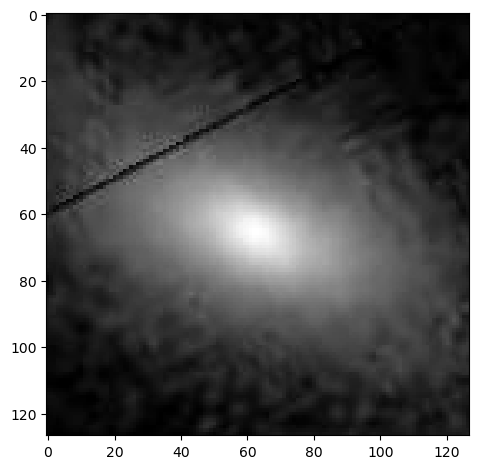

In [29]:
cropped_img = cropp_image(gray_img, galaxy.center[0], galaxy.center[1], galaxy.radius)
cropped_exposed_img = ski.exposure.rescale_intensity(cropped_img)
ski.io.imshow(cropped_exposed_img)


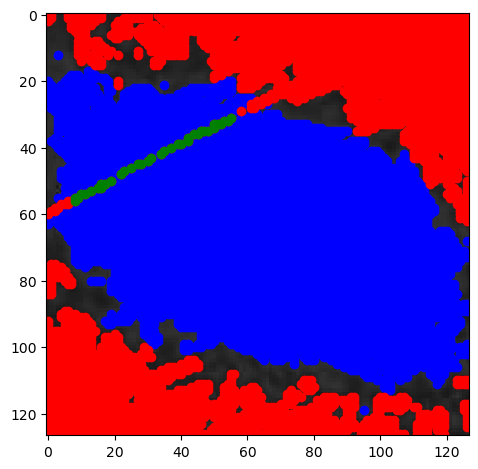

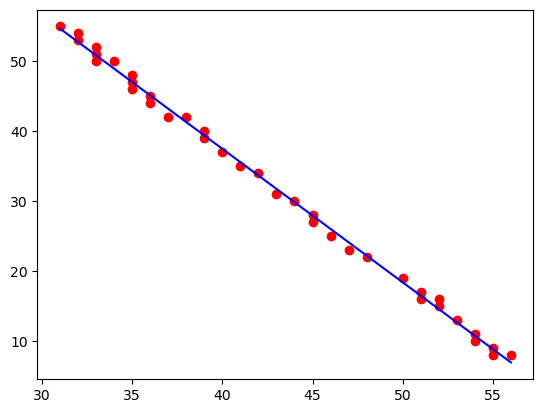

R^2 = 0.9975862307192267
Black Stripe found


True

In [30]:
check_for_black_stripe(cropped_exposed_img)

In [31]:
def get_covariance_matrix(image, x_size, y_size):
    coord_rows = []
    coord_columns = []
    for index_row in range(0, x_size):
        for index_column in range(0, y_size):
            if image[index_row][index_column] == 1:
                coord_rows.append(index_row)
                coord_columns.append(index_column)
    cov_matrix = np.cov(coord_rows, y=coord_columns)
    return cov_matrix


cov_matrix[0] = 	[89.72980486002233, 61.39920781564493]
cov_matrix[1] = 	[61.39920781564493, 240.27840687707868]
Eigenvalues     = 	[67.86460251017802, 262.143609226923]
eigenvectors[0] = 	[-0.9420481048079861, 0.3354778207686489]
eigenvectors[1] = 	[0.3354778207686489, 0.9420481048079861]
0.3354778207686489
0.3354778207686489
Rotating images with the deg -70.3984034094526


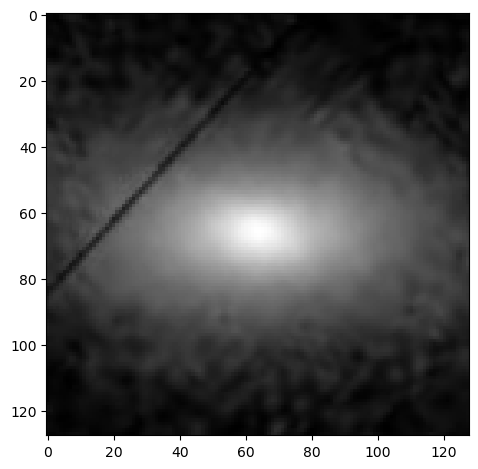

In [35]:
def get_rotation_on_image(image, verbose=False):
    binary_image = ski.util.img_as_bool(image)
    if verbose:
        ski.io.imshow(binary_image)
        pass
    
    cov_matrix = get_covariance_matrix(binary_image, len(binary_image), len(binary_image[0]))
    
    if verbose:
        print(f"cov_matrix[0] = \t[{cov_matrix[0][0]}, {cov_matrix[0][1]}]")
        print(f"cov_matrix[1] = \t[{cov_matrix[1][0]}, {cov_matrix[1][1]}]")
    result = np.linalg.eigh(cov_matrix)
    eigenvalues = result[0]
    eigenvectors = result[1]

    
    max_eigen_index, = np.where(np.isclose(eigenvalues, max(eigenvalues)))[0]
    if verbose:
        print(f"Eigenvalues     = \t[{eigenvalues[0]}, {eigenvalues[1]}]")
        print(f"eigenvectors[0] = \t[{eigenvectors[0][0]}, {eigenvectors[0][1]}]")
        print(f"eigenvectors[1] = \t[{eigenvectors[1][0]}, {eigenvectors[1][1]}]")
        print(eigenvectors[max_eigen_index][0])
        print(eigenvectors[(max_eigen_index+1)%2][1])
    rotations_in_radians = np.arccos((eigenvectors[max_eigen_index][0]+eigenvectors[(max_eigen_index+1)%2][1]) / 2)
    rotation_in_degrees = np.rad2deg(rotations_in_radians)
    if rotation_in_degrees > 90:
        rotation_in_degrees = 180 - rotation_in_degrees


    if (eigenvectors[max_eigen_index][0] * eigenvectors[max_eigen_index][1]) > 0:
        rotation_in_degrees = -rotation_in_degrees

    if verbose:
        print("Rotating images with the deg", rotation_in_degrees)
        # ski.io.imshow(ski.transform.rotate(image, rotation_in_degrees))

    return rotation_in_degrees+90

angle = get_rotation_on_image(cropped_exposed_img, verbose=True)
rotated_image = ski.transform.rotate(gray_img, angle)
cropped_rotated_img = cropp_image(rotated_image, galaxy.center[0], galaxy.center[1], galaxy.radius)
resized_cropped_rotated_image = ski.transform.resize(cropped_rotated_img, (128, 128))
resized_cropped_rotated_image = ski.exposure.rescale_intensity(resized_cropped_rotated_image)
ski.io.imshow(resized_cropped_rotated_image)

In [33]:
print("Hello")
raise SystemExit
print("This should not run")

Hello


SystemExit: 